# Credit churn - data exploration and modeling

0. [Introduction](#0)

1.  [Preparation](#1)

    1.1 [Packages](#1.1)
    
    1.2 [Data](#1.2)
    
    1.3 [Data dictionary](#1.3)
    
2. [EDA and visualization](#2)

3. [Classification model](#3)

    3.1 [Imputation, label encoding and baseline](#3.1)
    
    3.2 [Dataset balancing](#3.2)
    
    3.3 [Feature selection](#3.3)
    
    3.4 [Neural Networks?](#3.4)

## 0. Introduction <a id=0></a>

Credit card churning is a widespread phenomenon where people apply for multiple credit cards (or, more generally, open multiple credit lines) to take advntage of signup bonuses, with no intention of keeping all of them active in the long term. Credit institutions have therefore a strong interest in identifying churning customers and, more generally, predicting whether a client is gonna cancel their credit card or not. We perform data exploration on a dataset of 10000 customers with a view towards this goal and then build a predicting model.

## 1. Preparation <a id=1></a>

### 1.1 Packages <a id=1.1></a>

In [8]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import ADASYN, SMOTE

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf


init_notebook_mode(connected=True)
cf.set_config_file(sharing='public',theme='white',offline=True)

!pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastai.tabular.all import *
from fastbook import *

warnings.filterwarnings(action='ignore', category=UserWarning)

### 1.2 Data <a id=1.2></a>

As specified in the original dataset, we can drop the last two columns.

In [3]:
#import data and print first five rows of dataframe
df = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
df = df.iloc[:, :-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 1.3 Data dictionary <a id=1.3></a>

`CLIENTNUM` - ID of the customer holding the credit card.

`Customer_Age` - Age of the customer.

`Gender` - Sex of the customer.

`Dependent_count` - Number of dependents of the customer.

`Education_Level` - Educational qualification of the customer.

`Marital_Status` - Civil status of the customer.

`Income_Category` - Annual income range of the customer.

`Card_Category` - Type of card owned by the customer.

`Months_on_book` - Number of months elapsed since the account opening.

`Total_Relationship_Count` - Total number of products held by the customer.

`Months_Inactive_12_mon` - Number of months with no transactions in the last year.

`Contacts_Count_12_mon` - Number of contacts with the bank in the last year.

`Credit_Limit` - Credit limit on the credit card.

`Total_Revolving_Bal` - Total revolving balance on the credit card.

`Avg_Open_To_Buy` - Average card "Open To Buy" (=credit limit - account balance) in the last year.

`Total_Amt_Chng_Q4_Q1` - Change in transaction amount over the last year (Q4 over Q1).

`Total_Trans_Amt` - Total amount of transactions made in the last year.

`Total_Trans_Ct` - Number of transactions made in the last year.

`Total_Ct_Chng_Q4_Q1` - Change in transaction number over the last year (Q4 over Q1).

`Avg_Utilization_Ratio` - Average card "Utilization ratio" (=account balance / credit limit) in the last year.

`Attrition_Flag` - Target variable. "Attrited Customer" if the customer closed their account, otherwise "Existing Customer".

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

There are four categorical features, namely `Education_Level`, `Income_Category`, `Card_Category` and `Marital_Status`, in addition to the dependent variable `Attrition_Flag`. Even though the non-null count does not show any missing data, by looking at the different levels we see that there there are entries in the columns `Education_Level`, `Income_Category` and `Marital_Status` which are marked as *Unknown*.

## 2. EDA and visualization <a id=2></a>

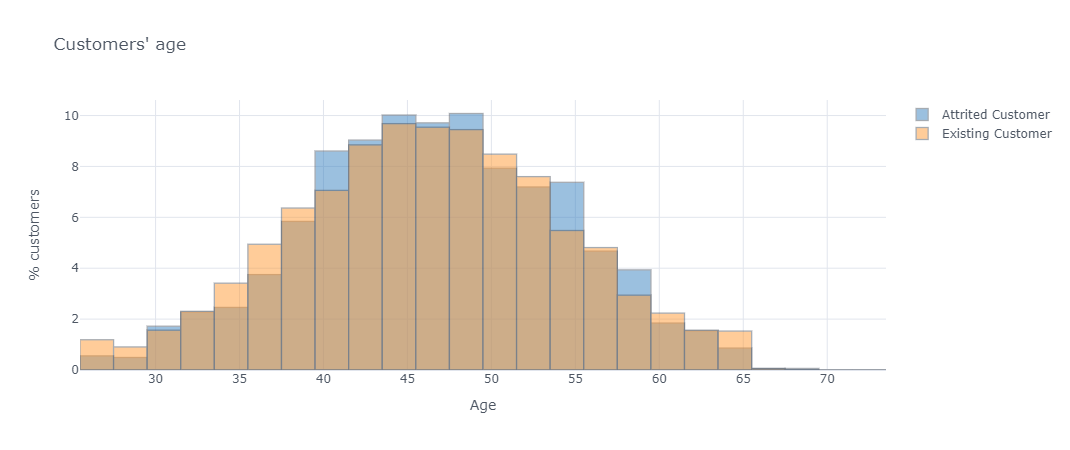

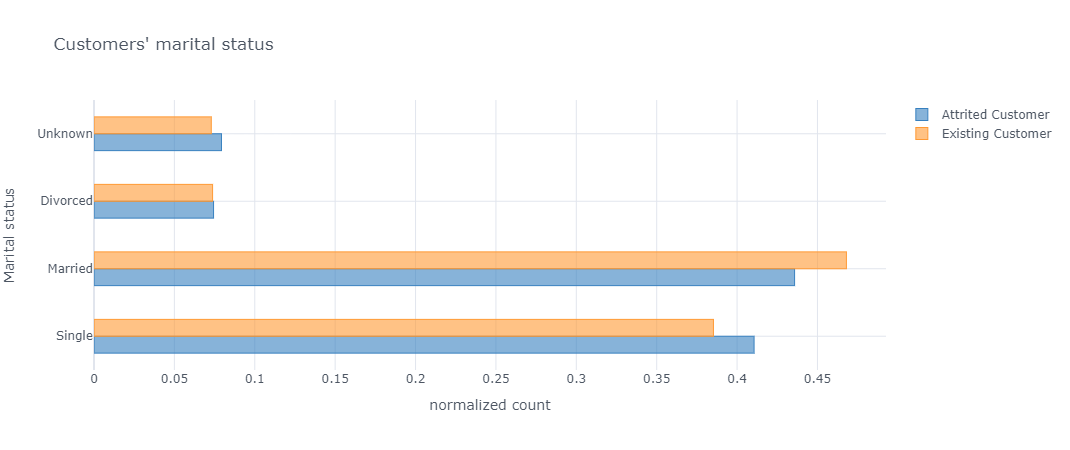

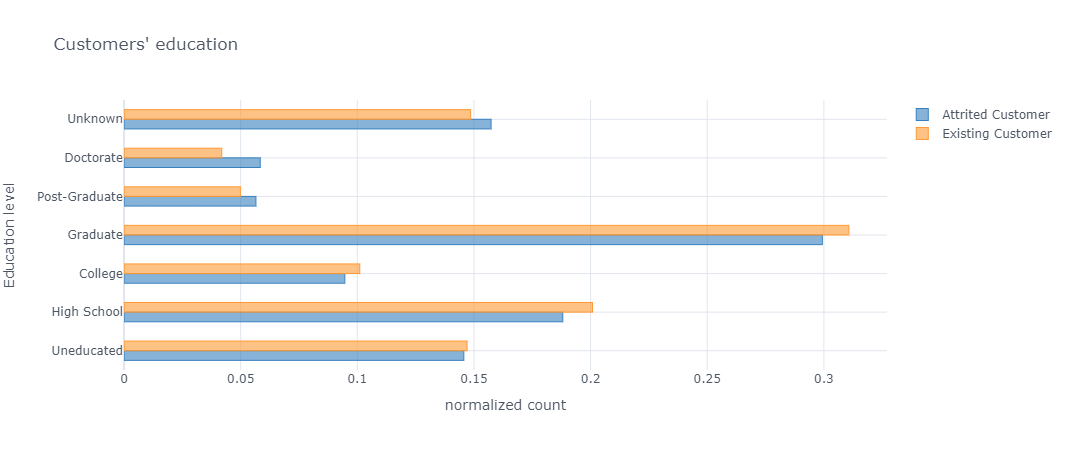

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



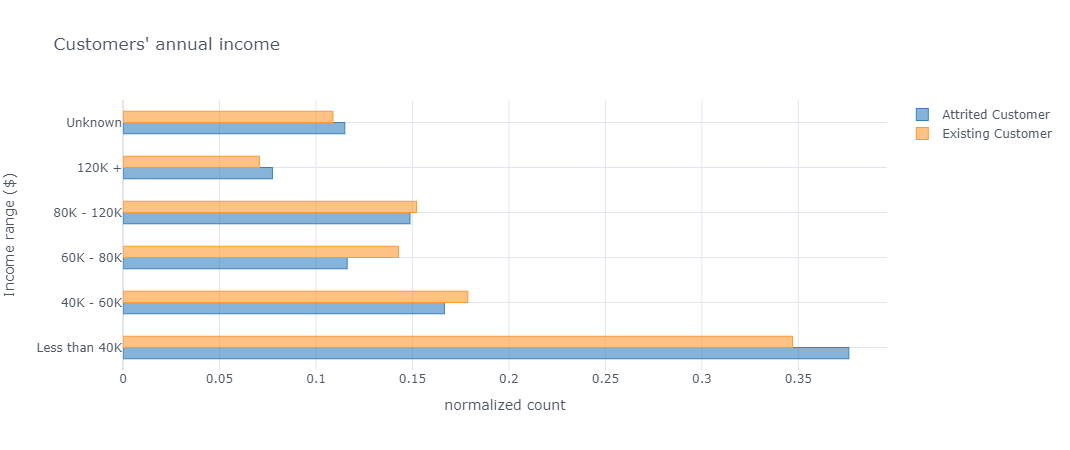

In [9]:
#Age histogram
age_att = df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'Customer_Age']
age_ex = df.loc[df['Attrition_Flag'] == 'Existing Customer', 'Customer_Age']
conc_age = pd.concat([age_att, age_ex], axis=1)
conc_age.columns = ['Attrited Customer', 'Existing Customer']
conc_age.iplot(kind='hist', keys=['Attrited Customer', 'Existing Customer'],
           colors=['blue', 'orange'], histnorm='percent', opacity=0.5, bins=30,
           title='Customers\' age', xTitle='Age', yTitle='% customers')

#Marital_Status normalized bar plot
mar_count = df.groupby(['Marital_Status', 'Attrition_Flag']).count()['CLIENTNUM'].unstack()
mar_count = mar_count.loc[['Single', 'Married', 'Divorced', 'Unknown']]
mar_count = mar_count / mar_count.sum()

mar_count.iplot(kind='bar', orientation='h',
                title='Customers\' marital status', xTitle='normalized count', yTitle='Marital status',                
                bargap=0.5, colors=['blue', 'orange'])

#Education_Level normalized bar plot
edu_count = df.groupby(['Education_Level', 'Attrition_Flag']).count()['CLIENTNUM'].unstack()
edu_count = edu_count.loc[['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate','Unknown']]
edu_count = edu_count / edu_count.sum()

edu_count.iplot(kind='bar', orientation='h', 
                title='Customers\' education', xTitle='normalized count', yTitle='Education level',                
                bargap=0.5, colors=['blue', 'orange'])

#Income_Category normalized bar plot
inc_count = df.groupby(['Income_Category', 'Attrition_Flag']).count()['CLIENTNUM'].unstack()
inc_count = inc_count.loc[['Less than $40K','$40K - $60K', '$60K - $80K' , '$80K - $120K', '$120K +', 'Unknown']]
inc_count.index = inc_count.index.str.replace('$', '')
inc_count = inc_count / inc_count.sum()

inc_count.iplot(kind='bar', orientation='h',
                title='Customers\' annual income', xTitle='normalized count', yTitle='Income range ($)',                
                bargap=0.5, colors=['blue', 'orange'])

Attrited customers seems to have a slightly higher education level and sliglty lower annual income, but overall from the demographic standpoint there are no striking differences between customers who have churned and customers who have not. Let us look at credit card usage and spending habits.

Churned customers' mean total transactions' amount: 3095.03$
Non-churned customers' mean total transactions' amount: 4654.66$


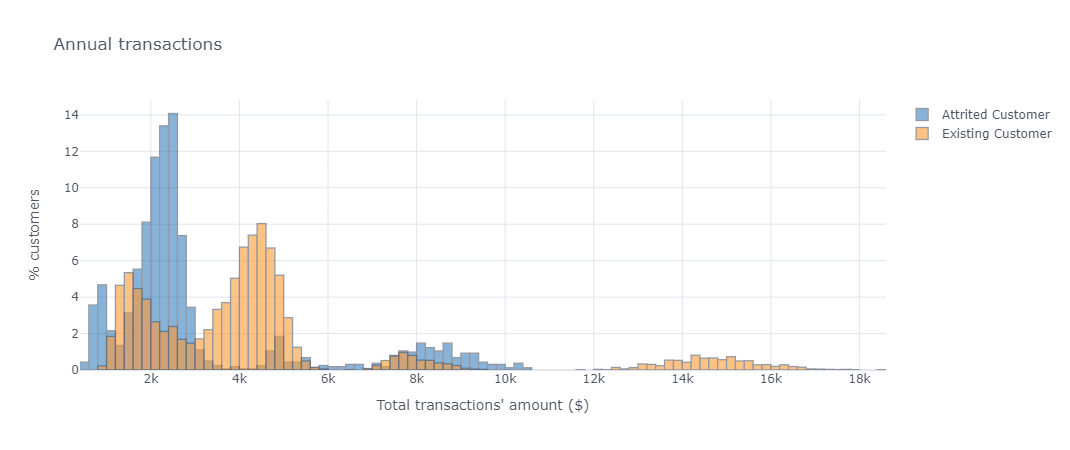

/opt/conda/lib/python3.7/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/opt/conda/lib/python3.7/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



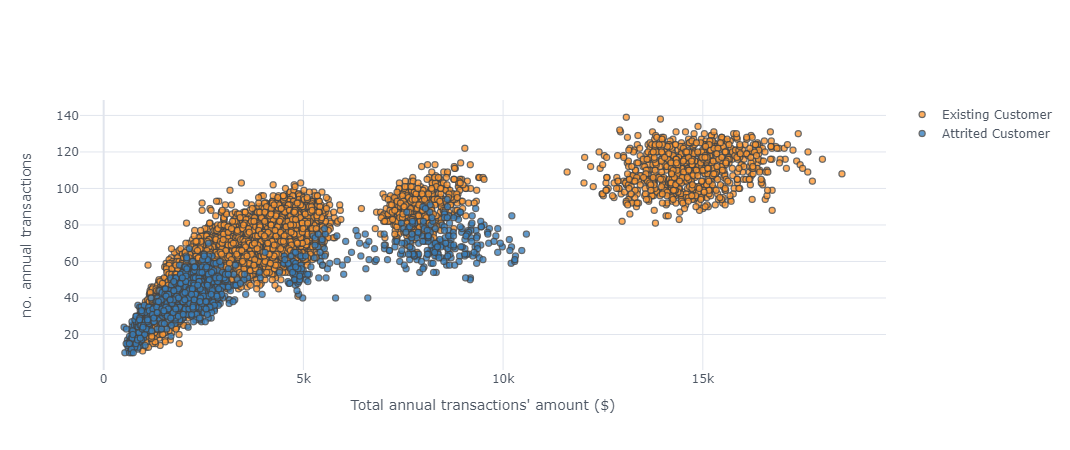

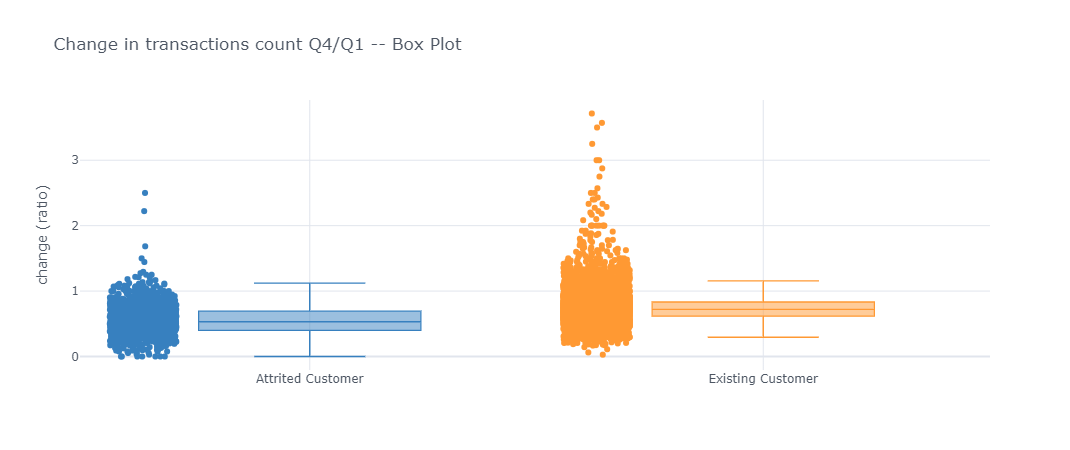

In [10]:
#Normalized histogram of annual transactions
df_att = df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'Total_Trans_Amt']
df_ex = df.loc[df['Attrition_Flag'] == 'Existing Customer', 'Total_Trans_Amt']
conc = pd.concat([df_att, df_ex], axis=1)
conc.columns = ['Attrited Customer', 'Existing Customer']

print("Churned customers' mean total transactions' amount: {:.2f}$".format(conc['Attrited Customer'].mean()))
print("Non-churned customers' mean total transactions' amount: {:.2f}$".format(conc['Existing Customer'].mean()))

conc.iplot(kind='hist', keys=['Attrited Customer', 'Existing Customer'],
           colors=['blue', 'orange'], histnorm='percent', opacity=0.6,
           title='Annual transactions', xTitle='Total transactions\' amount ($)', yTitle='% customers')

#Scatter plot: annual transactions' amount vs number
df.iplot(kind='scatter', x='Total_Trans_Amt', y='Total_Trans_Ct', categories='Attrition_Flag', size=6,
        xTitle='Total annual transactions\' amount ($)', yTitle='no. annual transactions')

df_att = df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'Total_Ct_Chng_Q4_Q1']
df_ex = df.loc[df['Attrition_Flag'] == 'Existing Customer', 'Total_Ct_Chng_Q4_Q1']
conc = pd.concat([df_att, df_ex], axis=1)
conc.columns = ['Attrited Customer', 'Existing Customer']

#Box plot of ratio of change in transactions' count over the last year
conc.iplot(kind='box', keys=['Attrited Customer', 'Existing Customer'],
           colors=['blue', 'orange'], opacity=0.5, boxpoints='all', legend=False,
           title='Change in transactions count Q4/Q1 -- Box Plot', yTitle='change (ratio)')

As it can be expected, we notice a direct correlation between the number of annual transactions and their total amount. More interestingly, it appears that we can segment the dataset into three different clusters of clients, one of which (high spenders, i.e. `Total_Trans_Amt` > 11k) contains no attrited customers at all. Churned customers used their credit card less often and spent significantly less money. They are also characterized by a more significant reduction in the usage of their credit card during the last 12 months.

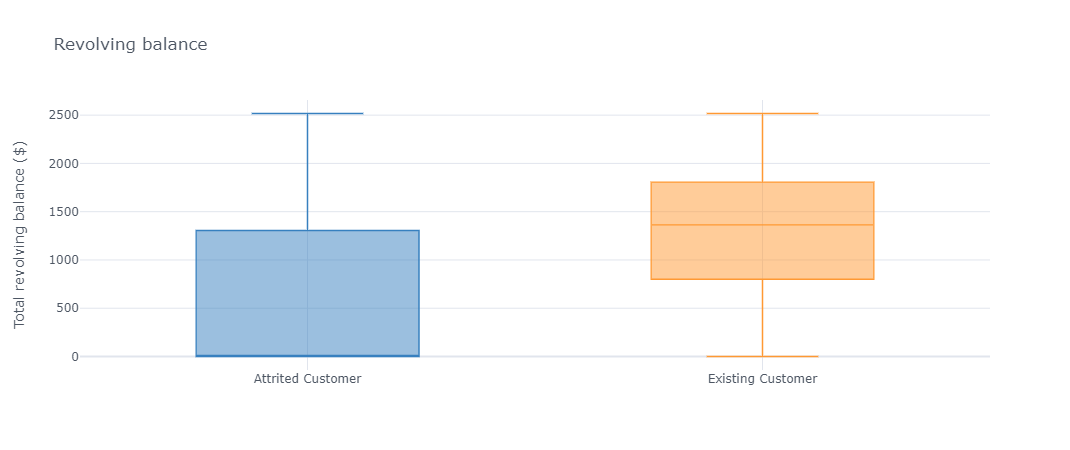

In [11]:
#Boxplot of revolving balance
df_att = df.loc[df['Attrition_Flag'] == 'Attrited Customer', 'Total_Revolving_Bal']
df_ex = df.loc[df['Attrition_Flag'] == 'Existing Customer', 'Total_Revolving_Bal']
conc = pd.concat([df_att, df_ex], axis=1)
conc.columns = ['Attrited Customer', 'Existing Customer']

conc.iplot(kind='box', keys=['Attrited Customer', 'Existing Customer'],
           colors=['blue', 'orange'], opacity=0.5, legend=False,
           title='Revolving balance', yTitle='Total revolving balance ($)')

We notice a major difference when analizying the revolving balance of the customers' credit lines: more than half of the churned customers have paid off all their debt. It is unclear whether this measure for the revolving balance is conducted before or after the termination of the credit line and whether customers who cancel their credit cards are asked to pay off all their standing debt. If this is the case, this feature has no real predicting value and should not be used for classification, as it is implicitly biased. However, since it was included in the dataset, we will use it in our models.

## 3. Classification model <a id=3></a>

### 3.1 Imputation, label encoding and baseline

We change the *Unknown* entries in the categorical features to NaN and then we impute such missing data, while label encoding all categorical features (we can treat `Education_Level`, `Income_Category` and `Card_Category` as ordinal features, and follow the obvious ordering in the choice of the labels). For the dependent variable, we will consider *Attrited Customer* as the positive class (label = 1).

In [12]:
income_ord = 'Less than $40K','$40K - $60K', '$60K - $80K' , '$80K - $120K', '$120K +'
edu_ord = 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'
card_ord = 'Blue', 'Silver', 'Gold', 'Platinum'
marital_status = 'Single', 'Married', 'Divorced'

df['Income_Category'] = df['Income_Category'].astype('category')
df['Income_Category'].cat.set_categories(income_ord, ordered=True, inplace=True)
df['Education_Level'] = df['Education_Level'].astype('category')
df['Education_Level'].cat.set_categories(edu_ord, ordered=True, inplace=True)
df['Card_Category'] = df['Card_Category'].astype('category')
df['Card_Category'].cat.set_categories(card_ord, ordered=True, inplace=True)
df['Marital_Status'] = df['Marital_Status'].astype('category')
df['Marital_Status'].cat.set_categories(marital_status, ordered=False, inplace=True)

dep_var = 'Attrition_Flag'
df[dep_var] = (df[dep_var] == 'Attrited Customer').astype(int)

print("# existing customers: {}\n".format(len(df.loc[df[dep_var] == 0])))
print("# attrited customers: {}\n".format(len(df.loc[df[dep_var] == 1])))

# existing customers: 8500

# attrited customers: 1627



Our dataset is **heavily unbalanced**: only 16% of the datapoints have `Attrition_Flag` = 1. This poses a problem which needs to be addressed, both while training classification models (to avoid bias) and while evaluating their performances (a naive model which always predicts `Attrition_Flag` = 0 will have an accuracy of almost 84%). In particular, as metric we will need to look separately at precision and recall for each of the two levels of the dependent variable, not just at the overall accuracy. Since the bank is especially interested in predicting which customers will churn, we will prioritize the recall for the positive class: this will be reflected in the choices fo the ROC thresholds.

As baseline, let us train a RandomForest classifier using all variables in the unbalanced dataset. We reserve a stratified 20% of data for validation.

OOB score: 0.961

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1698
           1       0.92      0.86      0.89       327

    accuracy                           0.97      2025
   macro avg       0.95      0.92      0.94      2025
weighted avg       0.97      0.97      0.97      2025



Text(0.5, 1.0, 'ROC curve - AUC=0.9867')

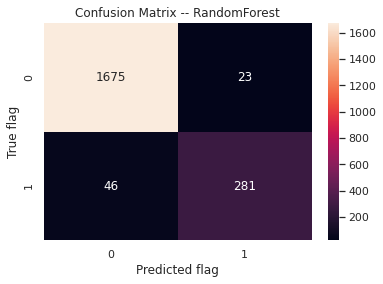

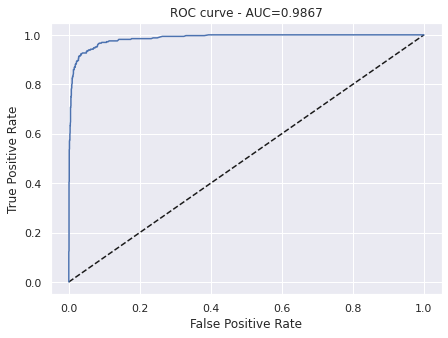

In [13]:
cont, cat = cont_cat_split(df, max_card=1, dep_var='Attrition_Flag')
procs = [Categorify, FillMissing]
to_rf1 = TabularPandas(df, procs, cat, cont, y_names=dep_var, y_block=CategoryBlock, splits=RandomSplitter()(range_of(len(df))))

train_X, train_y = to_rf1.train.xs, to_rf1.train.y
valid_X, valid_y = to_rf1.valid.xs, to_rf1.valid.y

rf1 = RandomForestClassifier(n_estimators=500, oob_score=True)
rf1.fit(train_X, train_y)
pred_y = rf1.predict(valid_X)

print("OOB score: {:.3f}\n".format(rf1.oob_score_))

print(classification_report(valid_y, pred_y))

sns.heatmap(confusion_matrix(valid_y, pred_y), annot=True, fmt='d')
plt.xlabel('Predicted flag')
plt.ylabel('True flag')
plt.title('Confusion Matrix -- RandomForest')

#ROC curve and AUC
probs = rf1.predict_proba(valid_X)
fpr, tpr, thr = roc_curve(valid_y, probs[:, 1])

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - AUC={:.4f}".format(roc_auc_score(valid_y, probs[:, 1])))

As we see from the classification report, the recall for the positive level of the dependent variable is significantly lower than the overall accuracy. This could be of course increased by lowering the probability threshold in the binary classification, at the cost of a precision reduction.

### 3.2 Dataset balancing <a id=3.2></a>
 
We can balance the dataset by adding synthetic data. We do so by using an upsampling algorithm like SMOTE or ADASYN. However, before upsampling we remove from the dataset a test set which we'll use for validation (and we repeat this over multiple folds). This is to prevent data leakage: we construct the synthetic datapoints (which will constitute almost half of the final training set) without them seeing the validation set, aiming for a more robust predictor.
We choose the probability threshold for predicting `Attrition_Flag` = 0/1 using ROC.

In [14]:
def test_model_oversamp(df, model, ovs_method, norm=False, n_iter=5, n_epochs=15, thr_mod=1):
    res = []
    roc = []
    procs=[Categorify, FillMissing]
    if norm == True:
        procs = procs + [Normalize]
    ind0 = df[df['Attrition_Flag'] == 0].index.to_list()
    ind1 = df[df['Attrition_Flag'] == 1].index.to_list()
    np.random.shuffle(ind0)
    np.random.shuffle(ind1)
    #Split the dataset into n_iter folds, with a 3:1 balancing of the dependent variable
    test_chks = [ind1[i::n_iter] for i in range(n_iter)]
    train_chks = [ind0[i::3*n_iter] for i in range(n_iter)]
    for i in range(n_iter):
        #Validation fold
        test_idx = test_chks[i] + train_chks[i]
        test_idx.sort()
        #Merge the training folds
        train_idx = [a for a in range(len(df)) if (a not in test_idx)]

        cont, cat = cont_cat_split(df, max_card=1, dep_var='Attrition_Flag')
        to = TabularPandas(df, procs, cat, cont, y_names='Attrition_Flag', y_block=CategoryBlock, splits=(train_idx, test_idx))
        train_X, train_y = to.train.xs, to.train.y
        test_X, test_y = to.valid.xs, to.valid.y

        #Upsampling of training set
        ovsX, ovsy = ovs_method.fit_resample(train_X, train_y) 
            
        #Neural Network setup using FastAI
        if model == nn:
            ovs_concat = pd.concat([to.valid.items, pd.concat([ovsX, pd.DataFrame({'Attrition_Flag':ovsy})], axis=1)]).reset_index().drop('index', axis=1)
            dls = TabularDataLoaders.from_df(ovs_concat, y_names='Attrition_Flag', y_block=CategoryBlock, valid_idx=range(len(test_idx)), bs=512)
            metrics = RocAucBinary()
            learn = tabular_learner(dls, metrics=metrics)
            learn.fit_one_cycle(n_epochs, 1e-2)
            probs, _ = learn.get_preds()
            probs = np.array(probs)
        else:
            ovsX = np.array(ovsX)
            test_X = np.array(test_X)
            model.fit(ovsX, ovsy)
            probs = model.predict_proba(test_X)
        
        #Choose probability threshold using ROC
        fpr, tpr, thr = roc_curve(test_y, probs[:, 1])
        best_thr = thr[np.argmin(fpr - tpr)]

        #Predictions of the model
        preds = np.where(probs[:, 1] > best_thr/thr_mod, 1, 0)

        #Accuracy and precision/recall scores
        acc = accuracy_score(test_y, preds)
        prec_rec = precision_recall_fscore_support(test_y, preds)
        res.append((acc, prec_rec[:2]))
        roc.append(roc_auc_score(test_y, probs[:, 1]))
        print("Iteration {} concluded".format(i+1))
  
    accu = np.mean([a for a,_ in res])
    accu_std = np.std([a for a,_ in res])
    auc = np.mean(roc)
    prec0 = np.mean([pr[0][0] for _,pr in res])
    prec0_std = np.std([pr[0][0] for _,pr in res])
    prec1 = np.mean([pr[0][1] for _,pr in res])
    prec1_std = np.std([pr[0][1] for _,pr in res])
    rec0 = np.mean([pr[1][0] for _,pr in res])
    rec0_std = np.std([pr[1][0] for _,pr in res])
    rec1 = np.mean([pr[1][1] for _,pr in res])
    rec1_std = np.std([pr[1][1] for _,pr in res])
    print("\nMean AUC score: {:.3f}".format(auc))
    print("\nMean accuracy: {0:.3f} (std: {1:.3f})".format(accu, accu_std))
    print("\nCLASS 0: \n \t mean precision: {0:.3f} (std: {1:.3f}), \t mean recall: {2:.3f} (std: {3:.3f})".format(prec0, prec0_std, rec0, rec0_std))
    print("CLASS 1: \n \t mean precision: {0:.3f} (std: {1:.3f}), \t mean recall: {2:.3f} (std: {3:.3f})".format(prec1, prec1_std, rec1, rec1_std))
    return res, roc  

In [15]:
rf = RandomForestClassifier(n_estimators=300, max_features='auto')
ovs_method = ADASYN()
res, roc = test_model_oversamp(df, rf, ovs_method=ovs_method)

Iteration 1 concluded
Iteration 2 concluded
Iteration 3 concluded
Iteration 4 concluded
Iteration 5 concluded

Mean AUC score: 0.984

Mean accuracy: 0.941 (std: 0.010)

CLASS 0: 
 	 mean precision: 0.966 (std: 0.010), 	 mean recall: 0.940 (std: 0.024)
CLASS 1: 
 	 mean precision: 0.903 (std: 0.034), 	 mean recall: 0.942 (std: 0.018)


Pretty good! With upsampling, the recall for the positive class has jumped to 94%, with a still good overall accuracy.
Let us try using a different model, namely XGBoost.

In [16]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, max_depth=25, eval_metric='logloss')
ovs_method = ADASYN()
res, roc = test_model_oversamp(df, model_xgb, ovs_method=ovs_method)

Iteration 1 concluded
Iteration 2 concluded
Iteration 3 concluded
Iteration 4 concluded
Iteration 5 concluded

Mean AUC score: 0.990

Mean accuracy: 0.951 (std: 0.007)

CLASS 0: 
 	 mean precision: 0.974 (std: 0.005), 	 mean recall: 0.949 (std: 0.009)
CLASS 1: 
 	 mean precision: 0.914 (std: 0.015), 	 mean recall: 0.955 (std: 0.009)


We see that XGB gives better overall results than RandomForest. We perform a randomized grid search for hyperparameter tuning.

In [17]:
to_all = TabularPandas(df, procs, cat, cont, y_names=dep_var, y_block=CategoryBlock)
train_X, train_y = to_all.train.xs, to_all.train.y

param_tuning = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [5, 10, 25, 40],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 400]
        }

model= xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid = RandomizedSearchCV(estimator=model, param_distributions=param_tuning)
grid.fit(train_X, train_y)

best_xgb = grid.best_estimator_

print(grid.best_params_)

ovs_method = ADASYN()
res, roc = test_model_oversamp(df, best_xgb, ovs_method=ovs_method)

{'subsample': 0.5, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Iteration 1 concluded
Iteration 2 concluded
Iteration 3 concluded
Iteration 4 concluded
Iteration 5 concluded

Mean AUC score: 0.991

Mean accuracy: 0.956 (std: 0.005)

CLASS 0: 
 	 mean precision: 0.970 (std: 0.005), 	 mean recall: 0.960 (std: 0.009)
CLASS 1: 
 	 mean precision: 0.932 (std: 0.015), 	 mean recall: 0.948 (std: 0.009)


### 3.3 Feature selection <a id=3.3></a>

Up until now we have worked with all features in the original dataset. It is worth looking at whether we can restrict to a subset of features (thus improving interpretability of the model) without losing prediction accuracy. To do so, we first train a RandomForest on all the dataset and take a look at the corresponding features importance.

OOB score: 0.965



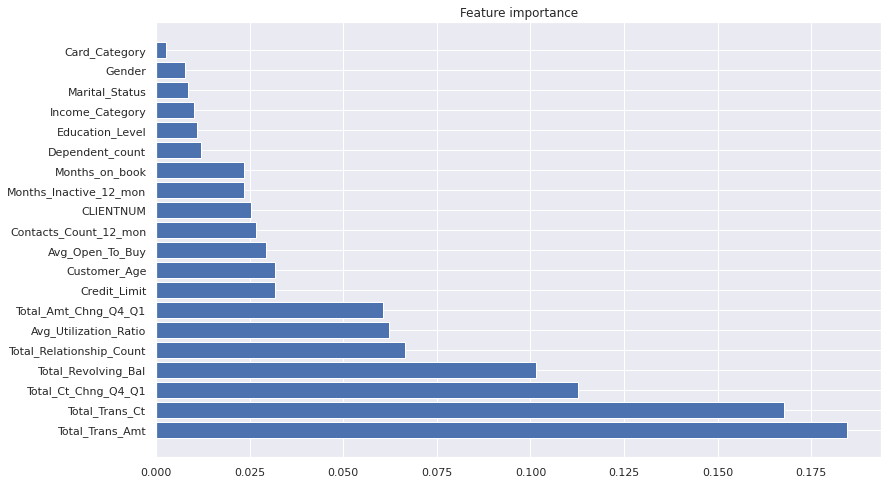

In [18]:
to_all = TabularPandas(df, procs, cat, cont, y_names=dep_var, y_block=CategoryBlock)

train_X, train_y = to_all.train.xs, to_all.train.y

rf_all = RandomForestClassifier(n_estimators=500, max_features='auto', oob_score=True)
rf_all.fit(train_X, train_y)

fi = pd.DataFrame({'feature':train_X.columns, 'feature_imp': rf_all.feature_importances_}).sort_values('feature_imp', ascending=False)
plt.subplots(figsize=(13,8))
plt.barh(fi.feature, fi.feature_imp)
plt.title("Feature importance")

print("OOB score: {:.3f}\n".format(rf_all.oob_score_))

We notice that all categorical features have low importance. The most signficant variables (namely `Total_Trans_Amt`, `Total_Trans_Ct`, `Total_Revolving_Bal` and `Total_Ct_Chng_Q4_Q1`) have been analyzed in the preliminary dataset exploration. Let's toss out the less important features and check how the OOB score changes.

OOB score: 0.966

Number of features: 14


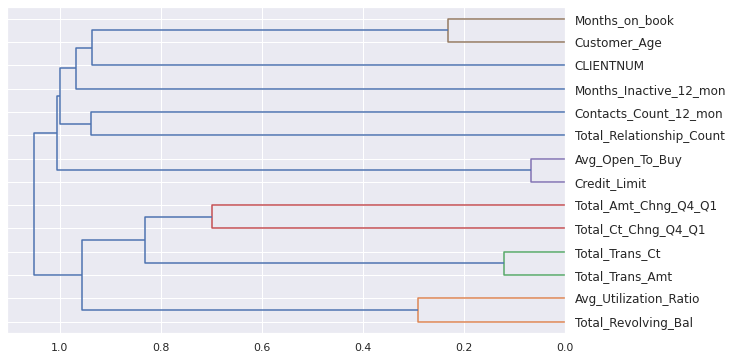

In [19]:
feat_filt = fi.loc[fi['feature_imp'] > 0.02, 'feature'].to_list()
x_filt = train_X[feat_filt]

rf_filt = RandomForestClassifier(n_estimators=500, oob_score=True)
rf_filt.fit(x_filt, train_y)

print("OOB score: {:.3f}\n".format(rf_filt.oob_score_))
print("Number of features: {}".format(len(feat_filt)))

cluster_columns(x_filt)

Passing from 20 features to just 14, the OOB score has actually slightly improved! Incidentally, we notice that we have tossed out all categorical features. Looking at the hierarchical feature clustering, it seems that we might also spare one feature between `Credit_Limit` and `Avg_Open_To_Buy` (we discard the second one, which has smaller importance). We also try removing `CLIENTNUM`, which we expect has no significant predicting value.

In [20]:
x_filt2 = train_X[feat_filt].drop(['Avg_Open_To_Buy', 'CLIENTNUM'], axis=1)

rf_filt2 = RandomForestClassifier(n_estimators=500, oob_score=True)
rf_filt2.fit(x_filt2, train_y)

print("OOB score: {:.3f}\n".format(rf_filt2.oob_score_))

OOB score: 0.968



The OOB score has not decreased. We restrict to the remaining 12 features and check the upsampled XGB algorithm CV performance as before.

In [21]:
df_fin = df[feat_filt + ['Attrition_Flag']].drop(['Avg_Open_To_Buy', 'CLIENTNUM'], axis=1)

model = best_xgb
ovs_method = ADASYN()
res, roc = test_model_oversamp(df_fin, model, ovs_method=ovs_method)

Iteration 1 concluded
Iteration 2 concluded
Iteration 3 concluded
Iteration 4 concluded
Iteration 5 concluded

Mean AUC score: 0.992

Mean accuracy: 0.960 (std: 0.001)

CLASS 0: 
 	 mean precision: 0.985 (std: 0.003), 	 mean recall: 0.952 (std: 0.005)
CLASS 1: 
 	 mean precision: 0.921 (std: 0.007), 	 mean recall: 0.975 (std: 0.005)


The overall performance has improved passing from the original 20 features to the 12 most significant ones, reaching an **AUC score of 99.2% and a recall for the positive class of over 97%**.

### 3.4 Neural Networks? <a id=3.4></a> 

Let us try using a neural network for the classification model, both with the total set of features and the filtered one. We train a 2-layers NN for 15 epochs and cross-validate as before.

In [22]:
#All features
res, roc = test_model_oversamp(df, nn, norm=True, ovs_method=ADASYN())

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.458190,0.353312,0.919466,00:00
1,0.318095,0.245741,0.962893,00:00
2,0.239789,0.249881,0.966095,00:00
3,0.192260,0.236772,0.969839,00:00
4,0.159226,0.260839,0.972025,00:00
5,0.126086,0.251375,0.975985,00:00
6,0.102919,0.247608,0.977754,00:00
7,0.087758,0.277525,0.978138,00:00
8,0.074213,0.276504,0.978419,00:00
9,0.058410,0.286420,0.979788,00:00


Iteration 1 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.459431,0.348428,0.923356,00:00
1,0.322401,0.244182,0.962725,00:00
2,0.244415,0.280862,0.961280,00:00
3,0.199256,0.258360,0.966350,00:00
4,0.167833,0.256373,0.973615,00:00
5,0.136226,0.241632,0.972728,00:00
6,0.114168,0.299732,0.977135,00:00
7,0.093774,0.277102,0.975179,00:00
8,0.076621,0.290268,0.978625,00:00
9,0.060232,0.284512,0.981051,00:00


Iteration 2 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.470492,0.361507,0.914894,00:00
1,0.323714,0.248724,0.962485,00:00
2,0.239755,0.202575,0.974842,00:00
3,0.187485,0.275098,0.965855,00:00
4,0.153453,0.251149,0.970615,00:00
5,0.128788,0.244515,0.972221,00:00
6,0.109201,0.241576,0.977078,00:00
7,0.093827,0.251625,0.978939,00:00
8,0.077007,0.260982,0.977165,00:00
9,0.062475,0.262493,0.978065,00:00


Iteration 3 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.469880,0.382381,0.916413,00:00
1,0.325703,0.281852,0.954318,00:00
2,0.244958,0.276233,0.956809,00:00
3,0.191735,0.232833,0.970316,00:00
4,0.152405,0.253932,0.971146,00:00
5,0.128136,0.217151,0.976687,00:00
6,0.103702,0.257566,0.973572,00:00
7,0.083320,0.275542,0.976128,00:00
8,0.066618,0.275559,0.977170,00:00
9,0.056081,0.271929,0.977903,00:00


Iteration 4 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.468484,0.358055,0.921026,00:00
1,0.326594,0.276274,0.956174,00:00
2,0.245052,0.300046,0.957634,00:00
3,0.193029,0.285620,0.961243,00:00
4,0.156743,0.262091,0.969974,00:00
5,0.130604,0.274041,0.973057,00:00
6,0.107764,0.264821,0.974088,00:00
7,0.089576,0.281114,0.974641,00:00
8,0.073349,0.294909,0.974809,00:00
9,0.060482,0.325554,0.976226,00:00


Iteration 5 concluded

Mean AUC score: 0.980

Mean accuracy: 0.928 (std: 0.002)

CLASS 0: 
 	 mean precision: 0.957 (std: 0.014), 	 mean recall: 0.928 (std: 0.017)
CLASS 1: 
 	 mean precision: 0.882 (std: 0.022), 	 mean recall: 0.926 (std: 0.026)


In [23]:
#Selected features
res, roc = test_model_oversamp(df_fin, nn, norm=True, ovs_method=ADASYN())

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.466355,0.318671,0.942610,00:00
1,0.329315,0.219265,0.969331,00:00
2,0.250892,0.185996,0.977846,00:00
3,0.204671,0.168109,0.982926,00:00
4,0.171917,0.164796,0.983970,00:00
5,0.144642,0.152855,0.986713,00:00
6,0.121364,0.167134,0.985160,00:00
7,0.103285,0.200734,0.981947,00:00
8,0.088745,0.185349,0.985815,00:00
9,0.079064,0.180137,0.987817,00:00


Iteration 1 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.484803,0.375193,0.930335,00:00
1,0.335753,0.218419,0.969450,00:00
2,0.254890,0.268291,0.965159,00:00
3,0.214764,0.203063,0.976759,00:00
4,0.171370,0.208625,0.978008,00:00
5,0.143245,0.184373,0.981601,00:00
6,0.118696,0.224528,0.979528,00:00
7,0.108283,0.241908,0.978371,00:00
8,0.091765,0.225994,0.980573,00:00
9,0.076184,0.225013,0.981974,00:00


Iteration 2 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.483629,0.355122,0.932902,00:00
1,0.339593,0.238120,0.965367,00:00
2,0.257305,0.291667,0.966062,00:00
3,0.206871,0.248831,0.969155,00:00
4,0.169162,0.241721,0.974940,00:00
5,0.142277,0.262446,0.972693,00:00
6,0.119188,0.228438,0.978622,00:00
7,0.098624,0.238439,0.980372,00:00
8,0.082613,0.228178,0.981853,00:00
9,0.070189,0.249955,0.979284,00:00


Iteration 3 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.468429,0.336909,0.941273,00:00
1,0.320358,0.254639,0.966186,00:00
2,0.243285,0.221889,0.975244,00:00
3,0.195811,0.207551,0.978168,00:00
4,0.166302,0.215298,0.978277,00:00
5,0.139245,0.209683,0.977420,00:00
6,0.115628,0.199960,0.983400,00:00
7,0.101957,0.205907,0.982705,00:00
8,0.087000,0.196901,0.984089,00:00
9,0.074468,0.219766,0.986167,00:00


Iteration 4 concluded


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.487308,0.311564,0.945055,00:00
1,0.340498,0.222281,0.969372,00:00
2,0.257889,0.227088,0.972362,00:00
3,0.214997,0.181613,0.981425,00:00
4,0.172537,0.210305,0.978831,00:00
5,0.142630,0.183386,0.982461,00:00
6,0.119163,0.197349,0.982868,00:00
7,0.103130,0.217886,0.986124,00:00
8,0.089563,0.183964,0.985495,00:00
9,0.077637,0.181975,0.986184,00:00


Iteration 5 concluded

Mean AUC score: 0.985

Mean accuracy: 0.939 (std: 0.004)

CLASS 0: 
 	 mean precision: 0.964 (std: 0.008), 	 mean recall: 0.940 (std: 0.006)
CLASS 1: 
 	 mean precision: 0.899 (std: 0.009), 	 mean recall: 0.939 (std: 0.015)


As before, using only the 12 most important features gives better results, but the NN approach does not perform as good as  XGB.